In [1]:
from langwahge.model import Model, loss_accuracy
from mynn.optimizers.sgd import SGD
import numpy as np
#from langwahge.coco_data import *
import random

C:\Users\g_bab\.conda\envs\week3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from pathlib import Path
from gensim.models import KeyedVectors
from collections import Counter
import json 
import re, string
import pickle
import mygrad as mg
class Coco:
    punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))
    
    def get_idf(self):
        """ 
        Given the vocabulary, and the word-counts for each document, computes
        the inverse document frequency (IDF) for each term in the vocabulary.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        nt: dict{string, float}
            A dictionary storing the IDF for each term in vocab
        """
        nt = {}
        N = len(self.counters)
        for t in self.vocab:
            total = 0
            for counter in self.counters:
                if t in counter:
                    total += 1

            nt[t] = np.log10(N / total)

        return nt
    
    def strip_punc(self, corpus):
        """ 
        Removes all punctuation from a string.

        Parameters
        ----------
        corpus : str

        Returns
        -------
        str
            the corpus with all punctuation removed
        """
        # substitute all punctuation marks with ""
        
        return self.punc_regex.sub('', str(corpus))
    
    def to_counter(self, doc):
        """ 
        Produce word-count of document, removing all punctuation
        and making all the characters lower-cased.
        
        Parameters
        ----------
        doc : str
        
        Returns
        -------
        collections.Counter
            lower-cased word -> count
        """
        return Counter(self.strip_punc(doc).lower().split())

    def to_vocab(self, counters, k=None):
        """ 
        Convert a collection of counters to a sorted list of the top-k most common words 
        
        Parameters
        ----------
        counters : Sequence[collections.Counter]
            A list of counters; each one is a word tally for a document
        
        k : Optional[int]
            If specified, only the top-k words are returned
            
        Returns
        -------
        List[str]
            A sorted list of the unique strings.
        """
        vocab = Counter()
        for counter in counters:
            vocab.update(counter)
            
        return sorted(i for i,j in vocab.most_common(k))

    def __init__(self): 
        """
        load COCO metadata (json file ["images"] ["annotations"])
        load glove data (dictionary {word : word_embedding})
        load in resnet data from resnet18_features.pkl (dictionary {img id : dvector})
        
        initialize the following attributes:
        image-ID -> [cap-ID-1, cap-ID-2, ...]
        caption-ID -> image-ID
        caption-ID -> caption (e.g. 24 -> "two dogs on the grass")
        
        initialize vocab list and counters list as attributes
       
        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        # load COCO metadata
        with Path(r"C:\Users\g_bab\Downloads\captions_train2014.json").open() as f:
            self.coco_data = json.load(f)
        
        # load GloVe-200 embeddings
        self.glove = KeyedVectors.load_word2vec_format(r"C:\Users\g_bab\Downloads\glove.6B.200d.txt.w2v", binary=False)

        # load image descriptor vectors
        with Path(r"C:\Users\g_bab\Downloads\resnet18_features.pkl").open('rb') as f:
            self.resnet18_features = pickle.load(f)
        
        self.imgid_to_capid = {}
        self.capid_to_imgid = {}
        self.capid_to_capstr = {}
        self.counters = []

        for caption in self.coco_data["annotations"]:
            # input caption_id to imgid_to_capid if the img_id key exists
            if self.imgid_to_capid.__contains__(caption["image_id"]):
                self.imgid_to_capid[caption["image_id"]].append(caption["id"])
            # else create new img_id object and create new caption_id list
            else:
                self.imgid_to_capid[caption["image_id"]] = [caption["id"]]

            # input img_id to capid_to_imgid
            self.capid_to_imgid[caption["id"]] = caption["image_id"]
            # input caption to capid_to_capstr
            self.capid_to_capstr[caption["id"]] = caption["caption"]
    
            self.counters.append(self.to_counter(caption))

        self.vocab = self.to_vocab(self.counters)
        
    def random_pair(self):
        """
        returns a random caption_string and respective image id

        Parameters
        ---------
        None
        
        Returns 
        -------
        Tuple(int, string)
            this contains the random caption_string and respective image id

        """    
        # random respective caption string
        captions = self.coco_data["annotations"]
        i = random.randint(len(captions)) 
        
        caption_info = captions[i]
        
        return caption_info["image_id"], caption_info["caption"]
        
    def vectorize_image(self, image_id):
        """
        takes in an image_id and returns the descriptor vector of the image

        Parameters
        ---------
        image_id: int
            unique integer ID for the image in coco_data
        
        Returns 
        -------
        image_dvector: np.array shape-(512,)
            a descriptor vector of the image as provided by RESNET
        """
        if image_id not in self.resnet18_features.keys():
            return np.zeros((512,))
        else:
            return self.resnet18_features[image_id]

    def embed_text(self, text_string):
        """
        returns normal_text_embedding

        Parameters
        ---------
        text_string: String
            a caption/query text 
        
        Returns 
        -------
        String
            normal text embedding
        """
        # returns normal_text_embedding
        # embed any caption / query text using GloVe-200 embeddings weighted by IDFs of words across captions (pass in either a user's query or existing caption)     
        # lowercase, remove punc, tokenize
        text_string = strip_punc(text_string).lower().split()

        text_embedding = []
        idf = self.get_idf()
        for word in text_string:
        # check if each word in given string is in glove[], if not then embedding vector 0
        # else get glove vector (200,) for it
            glove_vector = 0
            if word in self.glove:
                glove_vector = self.glove[word]
            
            idf_word = idf[word]
            text_embedding.append(glove_vector * idf_word)

        # add all together for the final phrase embed vector, then normalize
        normal_text_embedding = mg.sqrt(mg.einsum("ij, ij -> i", text_embedding, text_embedding)).reshape(-1, 1)

        # return normal_text_embedding
        return normal_text_embedding

    def get_data(self):
        """
        returns coco_data, glove , resnet18_features, imgid_to_capid, capid_to_imgid, capid_to_capstr, counters

        Parameters
        ---------
        None

        Returns 
        -------
        Tuple(dict, dict, dict)
            contains coco data, glove data, and resnet data
        """
        return (self.coco_data, self.glove, self.resnet18_features, self.imgid_to_capid, self.capid_to_imgid, self.capid_to_capstr, self.counters)

In [3]:
data = Coco()
_, glove, resnet18_features, imgid_to_capid, capid_to_imgid, capid_to_capstr, _ = data.get_data()

C:\Users\g_bab\.conda\envs\week3\lib\site-packages\noggin\plotter.py:364: UserWarning: Live plotting is not supported when matplotlib uses the 'module://ipykernel.pylab.backend_inline'
backend. Instead, use the 'nbAgg' backend.

In a Jupyter notebook, this can be activated using the cell magic:
   %matplotlib notebook.
  warn(cleandoc(_inline_msg.format(self._backend)))


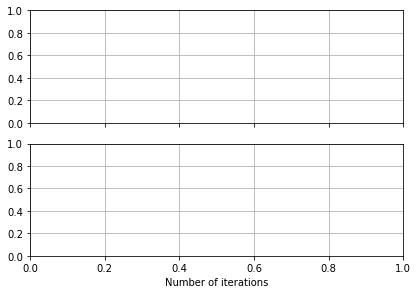

In [4]:
from noggin import create_plot
# plotter, fig, ax = create_plot(metrics=["loss"], max_fraction_spent_plotting=.75)
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"],  max_fraction_spent_plotting=.75)

In [5]:
triplets = []
# (caption_id, img_id, confuser_id)
for key in list(capid_to_imgid.keys()):
    caption_id = key
    img_id = capid_to_imgid[key]
    #values = np.array(list(imgid_to_capid.values()))
    conf_id = random.choice(list(capid_to_imgid.values()))
    if conf_id == img_id:
        conf_id = random.choice(list(capid_to_imgid.values()))
    triplets.append((caption_id, img_id, conf_id))
    #print(triplets)
    
#split the data
split_at = 0.8
split = int(len(triplets) * split_at)
train_triplets = triplets[:split] 
test_triplets = triplets[split:]



KeyboardInterrupt: 

In [ ]:
from mynn.optimizers.sgd import SGD
import numpy as np
#from .coco import *
import random

model = Model(512, 200)
optim = SGD(model.parameters, learning_rate = 1e-3, momentum =0.9)

In [ ]:
captionidlist = [i[0] for i in train_triplets]
list_phrases = [capid_to_capstr[i] for i in captionidlist]

w_captions = np.array([data.embed_text(i) for i in list_phrases])

captionidlisttest = [i[0] for i in test_triplets]
list_phrasestest = [capid_to_capstr[i] for i in captionidlisttest]

w_captionstest = np.array([data.embed_text(i) for i in list_phrasestest])

batch_size = 32
num_epochs = 30
for epoch in range(num_epochs):
    indexes = np.arange((len(train_triplets)))
    np.random.shuffle(indexes)
    for batch_count in range(0,len(train_triplets)//batch_size):
        batch_indexes = indexes[batch_count*batch_size: batch_count*(batch_size+1)]
        
        img_ids = [i[1] for i in train_triplets[batch_indexes]]
        
        img_batch = [data.vectorize_image(imgid) for imgid in img_ids]
        img_preds = model(np.array(img_batch))
        
        conf_ids = [j[2] for j in train_triplets[batch_indexes]]
        
        conf_batch = [data.vectorize_image(confid) for confid in conf_ids]
        conf_preds = model(np.array(conf_batch))
        #print(batch)
        #w_captions = data.embed_text(capid_to_capstr[train_triplets[batch_indexes][0]])  #should correspond to the vectors 
        #confuser = model(resnet18_features[random.choice(list(resnet18_features.keys())[:82600])])  
        #w_captions = data.embed_text(np.array([capid_to_capstr[i] for i in train_triplets[batch_indexes][0]]))
        
        # captionidlist = [i[0] for i in train_triplets[batch_indexes]]
        # list_phrases = [capid_to_capstr[i] for i in captionidlist]

        # w_captions = np.array([data.embed_text(i) for i in list_phrases])
        w_captions = w_captions[batch_indexes]

        sim_match = w_captions@img_preds
        sim_confuse = w_captions@conf_preds
        loss, acc = loss_accuracy(sim_match, sim_confuse, 0.25, train_triplets[batch_indexes])
        
        loss.backward()
        
        optim.step()
        
        plotter.set_train_batch({"loss" : loss.item(), "accuracy" : acc}, batch_size=batch_size)

filename = save_weights(model)

In [ ]:
#testing
with mg.no_autodiff:
    batch_size = 32
    num_epochs = 10000
    for epoch in range(num_epochs):
        indexes = np.arange((len(test_triplets)))
        np.random.shuffle(indexes)
        for batch_count in range(0,len(test_triplets)//batch_size):
            batch_indexes = indexes[batch_count*batch_size: batch_count*(batch_size+1)] 
            img_batch = data.vectorize_image(test_triplets[batch_indexes][1])
            img_preds = model(img_batch)
            conf_batch = data.vectorize_image(test_triplets[batch_indexes][2])
            conf_preds = model(conf_batch)
            #print(batch)
            #w_captions = data.embed_text(capid_to_capstr[test_triplets[batch_indexes][0]])  #should correspond to the vectors 
            #confuser = model(resnet18_features[random.choice(list(resnet18_features.keys())[:82600])])  
            #w_captions = data.embed_text(np.array([capid_to_capstr[i] for i in test_triplets[batch_indexes][0]]))
        
            list_phrases = [capid_to_capstr[i] for i in test_triplets[batch_indexes][0]]

            w_captions = np.array([data.embed_text(i) for i in list_phrases])

            sim_match = w_captions@img_preds
            sim_confuse = w_captions@conf_preds
            loss, acc = loss_accuracy(sim_match, sim_confuse, 0.25, len(test_triplets))
        
            loss.backward()
        
            optim.step()
        
            plotter.set_train_batch({"loss" : loss.item(), "accuracy" : acc}, batch_size=batch_size)